In [10]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [11]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 8:1:1
df = pd.read_csv('../../../Data/BNB-USD.csv')
df['Close'] = df['Close']
print(df)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df['Close'].iloc[:train_size]
test_data = df['Close'].iloc[train_size:train_size+test_size]
val_data = df['Close'].iloc[train_size+test_size:]

            Date        Open        High         Low       Close   Adj Close  \
0      11/9/2017    2.053140    2.174230    1.893940    1.990770    1.990770   
1     11/10/2017    2.007730    2.069470    1.644780    1.796840    1.796840   
2     11/11/2017    1.786280    1.917750    1.614290    1.670470    1.670470   
3     11/12/2017    1.668890    1.672800    1.462560    1.519690    1.519690   
4     11/13/2017    1.526010    1.735020    1.517600    1.686620    1.686620   
...          ...         ...         ...         ...         ...         ...   
2039   6/10/2023  260.698669  260.716095  233.169189  239.089081  239.089081   
2040   6/11/2023  239.087418  239.348267  234.430695  235.438797  235.438797   
2041   6/12/2023  235.403915  238.473221  222.071335  231.051437  231.051437   
2042   6/13/2023  231.075043  245.642197  229.311691  243.890533  243.890533   
2043   6/14/2023  243.890533  251.630157  234.042557  237.574265  237.574265   

          Volume  
0       19192200  
1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12890.184, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12944.293, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12914.219, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12918.762, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12942.866, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12904.042, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12907.316, Time=1.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12907.895, Time=4.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12891.272, Time=9.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12910.879, Time=2.68 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12904.166, Time=6.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12907.171, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12877.929, Time=4.24 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=12874.878, Time=6.45 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [15]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[384.82413044 383.93562833 387.37280998 387.32801994 384.1328326
 386.78734773 386.68775719 385.52051784 385.90286729 386.69151349
 385.79250383 385.9632505  386.31744251 386.09600121 385.92956934
 386.21801193 386.11816019 386.02284721 386.11772355 386.14143716
 386.05414407 386.09946219 386.12102574 386.08585435 386.0878095
 386.11247247 386.09443668 386.09114847 386.10294786 386.09943164]


In [16]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))
# EVS
evs = explained_variance_score(test_data, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
#MAPE
mape = mean_absolute_percentage_error(test_data, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The root mean squared error (RMSE) on test set: 109.579
The explained variance score (EVS) on test set: -0.002
The mean absolute percentage error (MAPE) on test set: 0.389


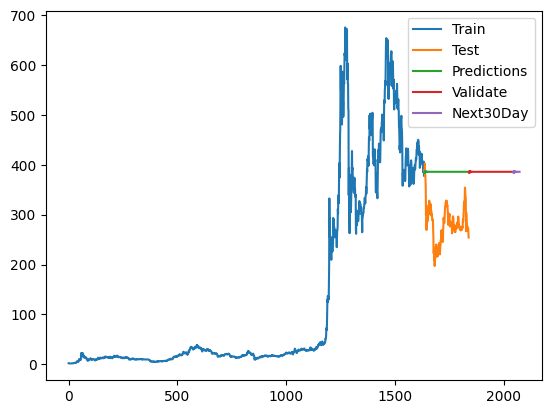

In [17]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [18]:
# test_data.index